In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os
os.chdir("final_project/")

In [3]:
from env import MazeEnv

In [8]:
maze = MazeEnv(8)

In [9]:
maze.grid.shape

(17, 17)

In [23]:
env = MazeEnv(10)

In [27]:
env.step("right")

([1, 0], 0, False)

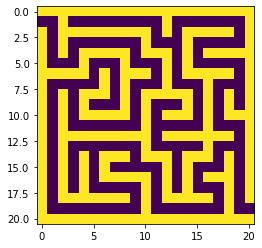

In [25]:
env.render()

In [59]:
class CNNCom(nn.Module):
    def __init__(self, input_shape=(2, 128, 128), n_p=2, n_theta=1):
        super().__init__()
        self.n_inv = 3 * n_theta * n_p
        self.conv = torch.nn.Sequential(
            # 128x128
            nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),s
            nn.MaxPool2d(2),
            # 64x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 32x32
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 16x16
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 8x8
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            # 6x6
            nn.MaxPool2d(2),
            # 3x3
            nn.Conv2d(512, 18, kernel_size=1, padding=0),
        )

        self.n_p = n_p
        self.n_theta = n_theta

        for m in self.named_modules():
            if isinstance(m[1], nn.Conv2d):
                # nn.init.kaiming_normal_(m[1].weight.data)
                nn.init.xavier_normal_(m[1].weight.data)
            elif isinstance(m[1], nn.BatchNorm2d):
                m[1].weight.data.fill_(1)
                m[1].bias.data.zero_()

    def forward(self, x):
        batch_size = x.shape[0]
        q = self.conv(x)
        q = q.reshape(batch_size, self.n_inv, 9).permute(0, 2, 1)
        return q

<>:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_835/276130058.py:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if obs_type is 'pixel':


In [62]:
class QLearningBuffer:
    def __init__(self, size):
        self._storage = []
        self._max_size = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def __getitem__(self, key):
        return self._storage[key]

    def __setitem__(self, key, value):
        self._storage[key] = value

    def add(self, data):
        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._max_size

    def sample(self, batch_size):
        batch_indexes = npr.choice(self.__len__(), batch_size).tolist()
        batch = [self._storage[idx] for idx in batch_indexes]
        return batch

    def getSaveState(self):
        return {
            'storage': self._storage,
            'max_size': self._max_size,
            'next_idx': self._next_idx
        }

    def loadFromState(self, save_state):
        self._storage = save_state['storage']
        self._max_size = save_state['max_size']
        self._next_idx = save_state['next_idx']

In [61]:
sys.path.append('./')
sys.path.append('..')
sys.path.append('../helping_hands_rl_envs')
from utils.parameters import *
from storage.buffer import QLearningBufferExpert, QLearningBuffer
from storage.per_buffer import PrioritizedQLearningBuffer, EXPERT, NORMAL
from storage.aug_buffer import QLearningBufferAug
from storage.per_aug_buffer import PrioritizedQLearningBufferAug
from utils.logger import Logger
from utils.schedules import LinearSchedule
from utils.env_wrapper import EnvWrapper

from utils.create_agent import createAgent
import threading

from utils.torch_utils import ExpertTransition, normalizeTransition, augmentBuffer

def set_seed(s):
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_step(agent, replay_buffer, logger, p_beta_schedule):
    batch = replay_buffer.sample(batch_size)
    loss, td_error = agent.update(batch)

    logger.trainingBookkeeping(loss, td_error.mean().item())
    logger.num_training_steps += 1
    if logger.num_training_steps % target_update_freq == 0:
        agent.updateTarget()

def preTrainCURLStep(agent, replay_buffer, logger):
    if buffer_type[:3] == 'per':
        batch, weights, batch_idxes = replay_buffer.sample(batch_size, per_beta)
    else:
        batch = replay_buffer.sample(batch_size)
    loss = agent.updateCURLOnly(batch)
    logger.trainingBookkeeping(loss, 0)

def saveModelAndInfo(logger, agent):
    logger.saveModel(logger.num_steps, env, agent)
    logger.saveLearningCurve(100)
    logger.saveLossCurve(100)
    logger.saveTdErrorCurve(100)
    logger.saveExpertSampleCurve(100)
    logger.saveEvalCurve()
    logger.saveRewards()
    logger.saveLosses()
    logger.saveTdErrors()
    logger.saveEvalRewards()

def evaluate(env, agent, logger):
    state = env.reset()
    evaled = 0
    temp_reward = [[] for _ in range(num_eval_processes)]
    eval_rewards = []
    if not no_bar:
        eval_bar = tqdm(total=num_eval_episodes)
    while evaled < num_eval_episodes:
        actions_star_idx, actions_star = agent.getGreedyActions(states, obs)
        states_, obs_, rewards, dones = envs.step(actions_star, auto_reset=True)
        rewards = rewards.numpy()
        dones = dones.numpy()
        states = copy.copy(states_)
        obs = copy.copy(obs_)
        for i, r in enumerate(rewards.reshape(-1)):
            temp_reward[i].append(r)
        evaled += int(np.sum(dones))
        for i, d in enumerate(dones.astype(bool)):
            if d:
                R = 0
                for r in reversed(temp_reward[i]):
                    R = r + gamma * R
                eval_rewards.append(R)
                temp_reward[i] = []
        if not no_bar:
            eval_bar.update(evaled - eval_bar.n)
    logger.eval_rewards.append(np.mean(eval_rewards[:num_eval_episodes]))
    if not no_bar:
        eval_bar.close()

def countParameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

def train():
    eval_thread = None
    start_time = time.time()
    if seed is not None:
        set_seed(seed)
    # setup env
    print('creating envs')
    envs = EnvWrapper(num_processes, simulator, env, env_config, planner_config)
    eval_envs = EnvWrapper(num_eval_processes, simulator, env, env_config, planner_config)

    # setup agent
    agent = createAgent()
    eval_agent = createAgent(test=True)
    # .train() is required for equivariant network
    agent.train()
    eval_agent.train()
    # if load_model_pre:
    #     agent.loadModel(load_model_pre)

    # logging
    log_dir = os.path.join(log_pre, '{}_{}'.format(alg, model))
    if note:
        log_dir += '_'
        log_dir += note

    logger = Logger(log_dir, env, 'train', num_processes, max_train_step, gamma, log_sub)
    hyper_parameters['model_shape'] = agent.getModelStr()
    logger.saveParameters(hyper_parameters)

    replay_buffer = QLearningBuffer(buffer_size)
    exploration = LinearSchedule(schedule_timesteps=explore, initial_p=init_eps, final_p=final_eps)
    p_beta_schedule = LinearSchedule(schedule_timesteps=max_train_step, initial_p=per_beta, final_p=1.0)

    if load_sub:
        logger.loadCheckPoint(os.path.join(log_dir, load_sub, 'checkpoint'), envs, agent, replay_buffer)

    if load_buffer is not None and not load_sub:
        logger.loadBuffer(replay_buffer, load_buffer, load_n)

    if planner_episode > 0 and not load_sub:
        planner_envs = envs
        planner_num_process = num_processes
        j = 0
        states, obs = planner_envs.reset()
        s = 0
        if not no_bar:
            planner_bar = tqdm(total=planner_episode)
        while j < planner_episode:
            plan_actions = planner_envs.getNextAction()
            planner_actions_star_idx, planner_actions_star = agent.getActionFromPlan(plan_actions)
            states_, obs_, rewards, dones = planner_envs.step(planner_actions_star, auto_reset=True)
            steps_lefts = planner_envs.getStepLeft()
            for i in range(planner_num_process):
                transition = ExpertTransition(states[i].numpy(), obs[i].numpy(), planner_actions_star_idx[i].numpy(),
                                              rewards[i].numpy(), states_[i].numpy(), obs_[i].numpy(), dones[i].numpy(),
                                              steps_lefts[i].numpy(), np.array(1))
                if obs_type == 'pixel':
                    transition = normalizeTransition(transition)
                replay_buffer.add(transition)
            states = copy.copy(states_)
            obs = copy.copy(obs_)

            j += dones.sum().item()
            s += rewards.sum().item()

            if not no_bar:
                planner_bar.set_description('{:.3f}/{}, AVG: {:.3f}'.format(s, j, float(s)/j if j != 0 else 0))
                planner_bar.update(dones.sum().item())
        if expert_aug_n > 0:
            augmentBuffer(replay_buffer, buffer_aug_type, expert_aug_n)

    # pre train
    if pre_train_step > 0:
        pbar = tqdm(total=pre_train_step)
        while len(logger.losses) < pre_train_step:
            t0 = time.time()
            train_step(agent, replay_buffer, logger, p_beta_schedule)
            if logger.num_training_steps % 1000 == 0:
                logger.saveLossCurve(100)
                logger.saveTdErrorCurve(100)
            if not no_bar:
                pbar.set_description('loss: {:.3f}, time: {:.2f}'.format(float(logger.getCurrentLoss()), time.time()-t0))
                pbar.update(len(logger.losses)-pbar.n)

            if (time.time() - start_time) / 3600 > time_limit:
                logger.saveCheckPoint(args, envs, agent, replay_buffer)
                exit(0)
        pbar.close()
        logger.saveModel(0, 'pretrain', agent)

    if not no_bar:
        pbar = tqdm(total=max_train_step)
        pbar.set_description('Episodes:0; Reward:0.0; Explore:0.0; Loss:0.0; Time:0.0')
    timer_start = time.time()

    states, obs = envs.reset()

    # TRAINING
    while logger.num_training_steps < max_train_step:

        # get epsilon
        if fixed_eps:
            eps = final_eps
        else:
            eps = exploration.value(logger.num_training_steps)

        is_expert = 0
        actions_star_idx, actions_star = agent.getEGreedyActions(states, obs, eps)  # NEED TO CHANGE

        envs.stepAsync(actions_star, auto_reset=False)

        if len(replay_buffer) >= training_offset:
            for training_iter in range(training_iters):
                train_step(agent, replay_buffer, logger, p_beta_schedule)

        # states_, obs_, rewards, dones = envs.stepWait()
        next_state, reward, done = envs.step() # TO DO
        # steps_lefts = envs.getStepLeft()

        # done_idxes = torch.nonzero(dones).squeeze(1)
        # if done_idxes.shape[0] != 0:
        if done:
            state = envs.reset() # TO DO
            # reset_states_, reset_obs_ = envs.reset_envs(done_idxes)
            # for j, idx in enumerate(done_idxes):
            #     states_[idx] = reset_states_[j]
            #     obs_[idx] = reset_obs_[j]

        # if not alg[:2] == 'bc':  # algorithm starts with bc ??
        #     for i in range(num_processes):
        #         transition = ExpertTransition(states[i].numpy(), obs[i].numpy(), actions_star_idx[i].numpy(),
        #                                       rewards[i].numpy(), states_[i].numpy(), obs_[i].numpy(), dones[i].numpy(),
        #                                       steps_lefts[i].numpy(), np.array(is_expert))
        #         if obs_type == 'pixel':
        #             transition = normalizeTransition(transition)
        #         replay_buffer.add(transition)
        # logger.stepBookkeeping(rewards.numpy(), steps_lefts.numpy(), dones.numpy())

        states = copy.copy(states_)
        obs = copy.copy(obs_)

        if (time.time() - start_time)/3600 > time_limit:
            break

        if not no_bar:
            timer_final = time.time()
            description = 'Action Step:{}; Reward:{:.03f}; Eval Reward:{:.03f}; Explore:{:.02f}; Loss:{:.03f}; Time:{:.03f}'.format(
                logger.num_steps, logger.getCurrentAvgReward(100), logger.eval_rewards[-1] if len(logger.eval_rewards) > 0 else 0, eps, float(logger.getCurrentLoss()),
                timer_final - timer_start)
            pbar.set_description(description)
            timer_start = timer_final
            pbar.update(logger.num_training_steps-pbar.n)
        logger.num_steps += num_processes

        if logger.num_training_steps > 0 and eval_freq > 0 and logger.num_training_steps % eval_freq == 0:
            if eval_thread is not None:
                eval_thread.join()
            eval_agent.copyNetworksFrom(agent)
            eval_thread = threading.Thread(target=evaluate, args=(eval_envs, eval_agent, logger))
            eval_thread.start()
            # evaluate(eval_envs, agent, logger)

        if logger.num_steps % (num_processes * save_freq) == 0:
            saveModelAndInfo(logger, agent)

    if eval_thread is not None:
        eval_thread.join()
    saveModelAndInfo(logger, agent)
    logger.saveCheckPoint(args, envs, agent, replay_buffer)
    if logger.num_training_steps >= max_train_step:
        logger.saveResult()
    # envs.close()
    # eval_envs.close()
    print('training finished')
    if not no_bar:
        pbar.close()

NameError: name 'sys' is not defined

In [30]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
points = [[-14.6, -2.5,0.],
          [-12.19105,-0.75,0.],
 [-10.71105,-0.75,0.      ],
 [ -8.591145,-3.245,0.      ],
 [ -8.091145,-3.245,0.      ],
 [ -3.73431,-1.7,0.      ],
 [ -1.433722,-0.85,0.      ],
 [ -0.933722,-0.85,0.      ],
 [  0.6,-3.,0.      ]]

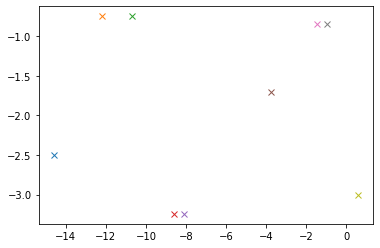

In [7]:
for point in points:
    plt.plot(point[0], point[1], 'x')

In [8]:
pos_set = [{'input_plane': [], 
  'constraints_plane': [[[-16.2, 3.6, -1], [-11.8283, 3.0, -1], [-11.8283, 3.0, 1], [-16.2, 3.6, 1]], 
                        [[-16.2, -4.7, -1], [-16.2, 3.6, -1], [-16.2, 3.6, 1], [-16.2, -4.7, 1]], 
                        [[-12.5538, -1.4, -1], [-16.2, -4.7, -1], [-16.2, -4.7, 1], [-12.5538, -1.4, 1]], 
                        [[-11.8283, 3.0, -1], [-11.8283, -0.1, -1], [-11.8283, -0.1, 1], [-11.8283, 3.0, 1]], 
                        [[-11.8283, -0.1, 1], [-12.5538, -1.4, 1], [-16.2, -4.7, 1], [-16.2, 3.6, 1], [-11.8283, 3.0, 1]], 
                        [[-11.8283, 3.0, -1], [-16.2, 3.6, -1], [-16.2, -4.7, -1], [-12.5538, -1.4, -1], [-11.8283, -0.1, -1]]], 
  'output_plane': [[-11.8283, -0.1, -1], [-12.5538, -1.4, -1], [-12.5538, -1.4, 1], [-11.8283, -0.1, 1]], 'corner_plane': []}, 
 {'input_plane': [[-11.8283, -0.1, 1], [-12.5538, -1.4, 1], [-12.5538, -1.4, -1], [-11.8283, -0.1, -1]], 
  'constraints_plane': [[[-11.8283, -0.1, -1], [-10.3483, -0.1, -1], [-10.3483, -0.1, 1], [-11.8283, -0.1, 1]], [[-11.0738, -1.4, -1], [-12.5538, -1.4, -1], [-12.5538, -1.4, 1], [-11.0738, -1.4, 1]], [[-11.0738, -1.4, 1], [-12.5538, -1.4, 1], [-11.8283, -0.1, 1], [-10.3483, -0.1, 1]], [[-10.3483, -0.1, -1], [-11.8283, -0.1, -1], [-12.5538, -1.4, -1], [-11.0738, -1.4, -1]]], 'output_plane': [[-10.3483, -0.1, -1], [-11.0738, -1.4, -1], [-11.0738, -1.4, 1], [-10.3483, -0.1, 1]], 
  'corner_plane': []}, 
 {'input_plane': [[-10.3483, -0.1, 1], [-11.0738, -1.4, 1], [-11.0738, -1.4, -1], [-10.3483, -0.1, -1]], 'constraints_plane': [[[-10.3483, -0.1, -1], [-6.10849, -1.9, -1], [-6.10849, -1.9, 1], [-10.3483, -0.1, 1]], [[-11.0738, -4.59, -1], [-11.0738, -1.4, -1], [-11.0738, -1.4, 1], [-11.0738, -4.59, 1]], [[-11.0738, -4.59, 1], [-11.0738, -1.4, 1], [-10.3483, -0.1, 1], [-6.10849, -1.9, 1]], [[-6.10849, -1.9, -1], [-10.3483, -0.1, -1], [-11.0738, -1.4, -1], [-11.0738, -4.59, -1]]], 'output_plane': [[-6.10849, -1.9, -1], [-11.0738, -4.59, -1], [-11.0738, -4.59, 1], [-6.10849, -1.9, 1]], 'corner_plane': [[[-10.9248407, -4.5093, -1.0], [-11.0738, -1.4, -1.0], [-11.0738, -1.4, 1], [-10.9248407, -4.5093, 1]]]}, {'input_plane': [[-6.10849, -1.9, 1], [-11.0738, -4.59, 1], [-11.0738, -4.59, -1], [-6.10849, -1.9, -1]], 'constraints_plane': [[[-6.10849, -1.9, -1], [-5.10849, -1.9, -1], [-5.10849, -1.9, 1], [-6.10849, -1.9, 1]], [[-11.0738, -4.59, 1], [-6.10849, -1.9, 1], [-5.10849, -1.9, 1]], [[-5.10849, -1.9, -1], [-6.10849, -1.9, -1], [-11.0738, -4.59, -1]]], 'output_plane': [[-5.10849, -1.9, -1], [-11.0738, -4.59, -1], [-11.0738, -4.59, 1], [-5.10849, -1.9, 1]], 'corner_plane': [[[-10.8948407, -4.5093, -1.0], [-10.9248407, -4.5093, -1.0], [-10.9248407, -4.5093, 1], [-10.8948407, -4.5093, 1]], [[-6.10849, -1.9, -1.0], [-5.2874493, -1.9807, -1.0], [-5.2874493, -1.9807, 1], [-6.10849, -1.9, 1]]]}, {'input_plane': [[-5.10849, -1.9, 1], [-11.0738, -4.59, 1], [-11.0738, -4.59, -1], [-5.10849, -1.9, -1]], 'constraints_plane': [[[-2.36013, -4.6, -1], [-11.0738, -4.59, -1], [-11.0738, -4.59, 1], [-2.36013, -4.6, 1]], [[-2.36013, -1.5, -1], [-2.36013, -4.6, -1], [-2.36013, -4.6, 1], [-2.36013, -1.5, 1]], [[-2.36013, -1.5, 1], [-2.36013, -4.6, 1], [-11.0738, -4.59, 1], [-5.10849, -1.9, 1]], [[-5.10849, -1.9, -1], [-11.0738, -4.59, -1], [-2.36013, -4.6, -1], [-2.36013, -1.5, -1]]], 'output_plane': [[-5.10849, -1.9, -1], [-2.36013, -1.5, -1], [-2.36013, -1.5, 1], [-5.10849, -1.9, 1]], 'corner_plane': [[[-10.8948407, -4.5093, -1.0], [-10.8948407, -4.5093, 1], [-2.36013, -4.6, 1], [-2.36013, -4.6, -1.0]], [[-5.2874493, -1.9807, -1.0], [-5.0260392, -1.888, -1.0], [-5.0260392, -1.888, 1], [-5.2874493, -1.9807, 1]], [[-2.4425808, -1.512, -1.0], [-2.36013, -4.6, -1.0], [-2.36013, -4.6, 1], [-2.4425808, -1.512, 1]]]}, {'input_plane': [[-5.10849, -1.9, 1], [-2.36013, -1.5, 1], [-2.36013, -1.5, -1], [-5.10849, -1.9, -1]], 'constraints_plane': [[[-5.10849, 1.2, -1], [-0.507314, 2.9, -1], [-0.507314, 2.9, 1], [-5.10849, 1.2, 1]], [[-5.10849, -1.9, -1], [-5.10849, 1.2, -1], [-5.10849, 1.2, 1], [-5.10849, -1.9, 1]], [[-0.507314, 2.9, -1], [-0.507314, -0.2, -1], [-0.507314, -0.2, 1], [-0.507314, 2.9, 1]], [[-0.507314, -0.2, 1], [-2.36013, -1.5, 1], [-5.10849, -1.9, 1], [-5.10849, 1.2, 1], [-0.507314, 2.9, 1]], [[-0.507314, 2.9, -1], [-5.10849, 1.2, -1], [-5.10849, -1.9, -1], [-2.36013, -1.5, -1], [-0.507314, -0.2, -1]]], 'output_plane': [[-0.507314, -0.2, -1], [-2.36013, -1.5, -1], [-2.36013, -1.5, 1], [-0.507314, -0.2, 1]], 'corner_plane': [[[-5.0260392, -1.888, -1.0], [-5.10849, 1.2, -1.0], [-5.10849, 1.2, 1], [-5.0260392, -1.888, 1]], [[-2.30454552, -1.461, -1.0], [-2.4425808, -1.512, -1.0], [-2.4425808, -1.512, 1], [-2.30454552, -1.461, 1]], [[-0.507314, 2.9, -1.0], [-0.5628984800000001, -0.23900000000000002, -1.0], [-0.5628984800000001, -0.23900000000000002, 1], [-0.507314, 2.9, 1]]]}, {'input_plane': [[-0.507314, -0.2, 1], [-2.36013, -1.5, 1], [-2.36013, -1.5, -1], [-0.507314, -0.2, -1]], 'constraints_plane': [[[-1.36013, -1.5, -1], [-2.36013, -1.5, -1], [-2.36013, -1.5, 1], [-1.36013, -1.5, 1]], [[-2.36013, -1.5, 1], [-0.507314, -0.2, 1], [-1.36013, -1.5, 1]], [[-1.36013, -1.5, -1], [-0.507314, -0.2, -1], [-2.36013, -1.5, -1]]], 'output_plane': [[-0.507314, -0.2, -1], [-1.36013, -1.5, -1], [-1.36013, -1.5, 1], [-0.507314, -0.2, 1]], 'corner_plane': [[[-2.30454552, -1.461, -1.0], [-2.30454552, -1.461, 1], [-1.36013, -1.5, 1], [-1.36013, -1.5, -1.0]], [[-0.5628984800000001, -0.23900000000000002, -1.0], [-0.5328984800000001, -0.23900000000000002, -1.0], [-0.5328984800000001, -0.23900000000000002, 1], [-0.5628984800000001, -0.23900000000000002, 1]]]}, {'input_plane': [[-0.507314, -0.2, 1], [-1.36013, -1.5, 1], [-1.36013, -1.5, -1], [-0.507314, -0.2, -1]], 'constraints_plane': [[[-0.507314, -0.2, -1], [0.492686, -0.2, -1], [0.492686, -0.2, 1], [-0.507314, -0.2, 1]], [[-1.36013, -4.6, -1], [-1.36013, -1.5, -1], [-1.36013, -1.5, 1], [-1.36013, -4.6, 1]], [[3.5, -4.7, -1], [-1.36013, -4.6, -1], [-1.36013, -4.6, 1], [3.5, -4.7, 1]], [[0.492686, -0.2, -1], [3.5, -4.7, -1], [3.5, -4.7, 1], [0.492686, -0.2, 1]], [[3.5, -4.7, 1], [-1.36013, -4.6, 1], [-1.36013, -1.5, 1], [-0.507314, -0.2, 1], [0.492686, -0.2, 1]], [[0.492686, -0.2, -1], [-0.507314, -0.2, -1], [-1.36013, -1.5, -1], [-1.36013, -4.6, -1], [3.5, -4.7, -1]]], 'output_plane': [], 'corner_plane': [[[-0.5328984800000001, -0.23900000000000002, -1.0], [0.492686, -0.2, -1.0], [0.492686, -0.2, 1], [-0.5328984800000001, -0.23900000000000002, 1]]]}]

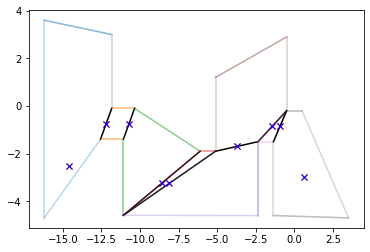

In [55]:
for i, dict in enumerate(pos_set):
    for c in dict['constraints_plane']:
        plt.plot([c[0][0], c[1][0]], [c[0][1], c[1][1]], color=f'C{i}', alpha=.3)
    o = dict["output_plane"]
    if len(o)>0:
        plt.plot([o[0][0], o[1][0]], [o[0][1], o[1][1]], color='k')
for point in points:
    plt.plot(point[0], point[1], 'rx')
for point in d_ordered:
    if sum(point) != 0:
        plt.plot(point[0], point[1], 'bx')

In [52]:
t_set_sim = np.array([7.97740915, 1.70710861, 4.41392083, 0.99735181, 2.18784392, 1.15030701, 1.43960794, 8.88727877])
d_ordered = np.array([[-14.6     ,  -2.5     ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [-12.19105 ,  -0.75    ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [-10.71105 ,  -0.75    ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [ -8.591145,  -3.245   ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [ -8.091145,  -3.245   ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [ -3.73431 ,  -1.7     ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [ -1.433722,  -0.85    ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [ -0.933722,  -0.85    ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.6     ,  -3.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ]])
d_ordered_yaw = np.array([[ 1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [-3.98323505e-15,  0.00000000e+00],
       [-1.05997859e-14,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 4.11448156e-14,  0.00000000e+00],
       [-1.10963887e-14,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [-1.42055045e-14,  0.00000000e+00],
       [-9.39518852e-16,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 2.42034004e-14,  0.00000000e+00],
       [-2.89908674e-14,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 5.48147186e-15,  0.00000000e+00],
       [-7.73089798e-15,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])
alpha_sim = 9.69

In [32]:
N=10
v = np.array([1, -3, 3 ,-1]) # Minimize jerk
A = np.zeros((N+3,N))
for i in range(N+3):
    for j in range(min(i,N-1),max(i-4,-1),-1):
        A[i,j] = v[j-i+3]
R = A.T.dot(A)
cov = np.linalg.inv(R)

In [46]:
A

array([[-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-3.,  3., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -3.,  3., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -3.,  3., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -3.,  3., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -3.,  3., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -3.,  3., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -3.,  3., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -3.,  3., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -3.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])